In [2]:
#MODULE NAME
import os
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.exposure as exposure
import pandas as pd
import numpy as np
import subprocess
import snappy
import imageio
import rasterio as rio
import rasterstats as rs
import rasterio.plot 
from glob import iglob
import geopandas as gpd
from pyspatialml import Raster
import seaborn as sns
from rasterio.plot import show
get_ipython().run_line_magic('matplotlib', 'inline')
from osgeo import gdal
import prosail
from prosail import spectral_lib
import numpy as np
import numpy.matlib
import numpy as np
from numpy.random import seed
from numpy.random import rand
import numpy.matlib
import matplotlib.pyplot as plt
import pandas as pd

In [134]:
#Installing packages

#Needed for step 1 - data generation

#Installing PROSAIL
#!pip install prosail

#latin hypercube stuff
#lets try to do a LHS
#!pip install lhsmdu

#this package as a number of functions to deal with hyperspectral data
#!pip install pysptools

#General purpose: 
import matplotlib.pyplot as plt
import numpy
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd

#PROSPECT+SAIL Radiative transfer mode package
import prosail

#Sampling design package
import lhsmdu

#package to for operations on spectral data
import pysptools as sptool 
from pysptools import distance
#machine learning packages are imported later, nearer to the model
from numpy.random import seed
from numpy.random import rand
import numpy.matlib
import matplotlib.pyplot as plt
import pandas as pd

In [388]:
np.random.seed(0)
krange=200000
n=1.28
chloro= rand(krange)*80
caroten=rand(krange)*10
brown=rand(krange)*1
EWT=rand(krange)*0.009
LMA=rand(krange)*0.009
LAI=rand(krange)*10
hot_spot=0.1
tts = 25.6800490939937 # solar zenith angle (in degrees)
tto = 0 # sensor zenith angle (in degrees)
psi = 66.2901524550189 # Azimuth angle - difference between sun and sensor (in degrees)
typelidf=1
lidfa = -1 #leaf angle distribution parameter a and b (Spherical)
lidfb=0
rsoil = 1 # soil reflectance 
psoil = 1 #soil reflectance at the red edge position 

#soilType=pyPro4SAIL.DEFAULT_SOIL
#sal=len(solar_zenith)
#rho=np.zeros((sal,krange,2101))
rho_out = np.zeros((krange,2101))
for i in range(krange):
    rho_out[i,:] = prosail.run_prosail(1.2,chloro[i],caroten[i],brown[i], EWT[i], LMA[i], LAI[i], lidfa,hot_spot[i],tts,tto,psi, typelidf=1, lidfb=0,
                                 factor='DHR', rsoil=1, psoil= 1)


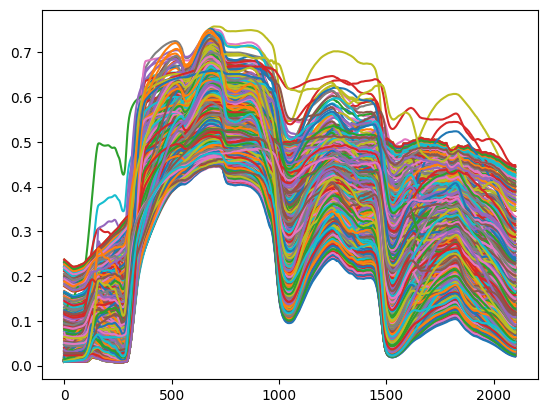

In [369]:
plt.plot(rho_out.T);

In [370]:
#this function also transforms the hyperspectral data to sentinel data
def Prosail2S2(path2csv, spectra_input):
    #importing pandas
    import pandas as pd
    import numpy
    import numpy as np
    
    s2_table = pd.read_csv(path2csv,sep=";",decimal=",") #check if this is proper, regarding the sep and dec
    s2_table_sel = s2_table[s2_table['SR_WL'].between(400,2500)] #selects all values between 400 and 2500
    spectra_input_df = pd.DataFrame(data=spectra_input,columns=["rho"],index=s2_table_sel.index) #transforms the input array into a pandas df with the column name rho and row.index = to the original input table

  
    rho_s2 = s2_table_sel.multiply(spectra_input_df['rho'],axis="index") #calculates the numerator
    w_band_sum = s2_table_sel.sum(axis=0,skipna = True) #calculates the denominator

    output = (rho_s2.sum(axis=0)/w_band_sum).rename_axis("ID").values #runs the weighted mean and converts the output to a numpy array

    return output[1:] #removes the first value because it represents the wavelength column

#please LOAD THTE FILE NOW
filepath="/Users/BSibiya/Desktop/Sandberg Fynbos Reserve/S2_response.csv"


In [1]:
tr_rho_s = np.zeros((1000, 13))
for i in range(1000):
    tr_rho_s[i, :] = Prosail2S2(filepath,  rho_out[i,0:2101].T)[np.array((1,2,3,4,5,6,7,8,9,10,11,12,13))]
print(tr_rho_s.shape)
simulated = pd.DataFrame(tr_rho_s)

NameError: name 'np' is not defined

In [371]:
tr_rho_s = np.zeros((1000, 9))
for i in range(1000):
    tr_rho_s[i, :] = Prosail2S2(filepath,  rho_out[i,0:2101].T)[np.array((2,3,4,5,6,7,8,11,12))]
print(tr_rho_s.shape)

simulated = pd.DataFrame(tr_rho_s, columns = ('BAND_2', 'BAND_3', 'BAND_4', 'BAND_5', 'BAND_6', 'BAND_7', 'BAND_8', 'BAND_11', 'BAND_12'))


(1000, 9)


In [372]:
simulated

,BAND_2,BAND_3,BAND_4,BAND_5,BAND_6,BAND_7,BAND_8,BAND_11,BAND_12
0,0.033558,0.010161,0.067389,0.284777,0.398609,0.454217,0.486730,0.367299,0.199964
1,0.139985,0.153847,0.198007,0.311951,0.360252,0.390391,0.407878,0.441710,0.356858
2,0.053415,0.041837,0.094178,0.248776,0.320727,0.365701,0.391972,0.375127,0.226322
3,0.026730,0.009775,0.058820,0.211500,0.298462,0.364401,0.404842,0.275610,0.129471
4,0.033793,0.012432,0.074730,0.239840,0.337996,0.420982,0.472496,0.338782,0.188123
...,...,...,...,...,...,...,...,...,...
995,0.112514,0.061840,0.196963,0.342471,0.408351,0.459102,0.488510,0.272543,0.129758
996,0.080545,0.064974,0.132563,0.309269,0.375971,0.410592,0.430499,0.467833,0.363196
997,0.015915,0.007587,0.035639,0.191204,0.289055,0.348224,0.384122,0.245344,0.107345
998,0.046476,0.022471,0.099221,0.211478,0.276358,0.337229,0.374534,0.283223,0.130389


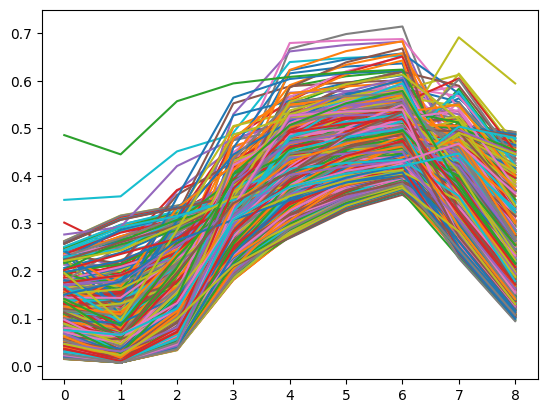

In [373]:
plt.plot(tr_rho_s.T);

# Dataframes to store values of extracted pixel

In [374]:
from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import r2_score

In [375]:
dataframe = r'C:\Users\BSibiya\Desktop\Sandberg Fynbos Reserve\dataset.xlsx'
df = pd.read_excel(dataframe)
#measured.head()

In [376]:
measured = df[['BAND_2', 'BAND_3', 'BAND_4', 'BAND_5','BAND_6', 'BAND_7', 'BAND_8', 'BAND_11','BAND_12']]
measured.head()
df_chloro = df[['CHLORO']]
df_chloro.head()

,CHLORO
0,21.22768
1,22.22008
2,23.79424
3,20.47040
4,20.31208


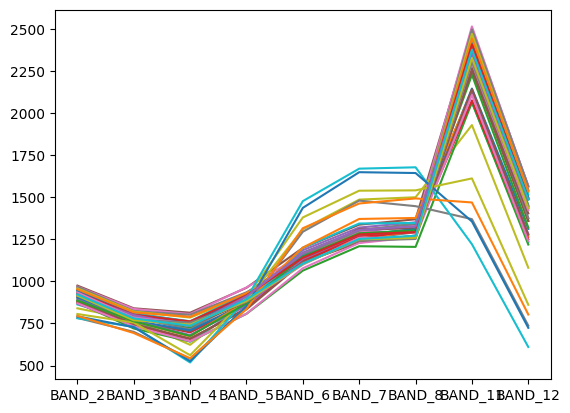

In [377]:
plt.plot(measured.T);

In [378]:
meas=np.array(measured)/np.mean(np.array(measured))*np.mean(np.array(simulated))
cab = []
rmse = []
for i in np.arange(40):
#     print(np.sum((np.array(simulated)-np.array(measured)[i,:])**2,axis=1))
    mses=np.sum((np.array(simulated)-meas[i,:])**2,axis=1)
    ind=np.argmin(mses)
    cab.append(chloro[i])
    #print(chloro[i])
    print(ind, mses[ind])
    rmse.append(mses[ind])
    
chlorophyll = pd.DataFrame(cab, columns = ['chlor'])


244 0.052639631505981624
244 0.049169697946073586
763 0.04547714761694365
244 0.05349775500764466
244 0.0533477739644032
244 0.047103448013889396
244 0.052437361548837894
244 0.058130975143052134
244 0.05505929117728642
244 0.05311973045084023
244 0.05375753001867649
244 0.05474356619906318
763 0.053725814331115056
763 0.04560957775982552
763 0.04050580679233316
763 0.04257108220191918
763 0.04865982927139685
763 0.0429130561153275
166 0.02295230568930088
763 0.03282097671446178
763 0.03974415380915193
763 0.03191711103081427
763 0.049420489498133595
763 0.03963553788705662
763 0.0403476885295745
763 0.044568153673516256
763 0.04626358611235308
655 0.019955653951595518
233 0.016658319524915637
655 0.021491587677482642
655 0.019620515101130744
233 0.0199846141500903
763 0.042041179792126314
244 0.05255063375253586
763 0.045863861886552504
763 0.04842881098627314
763 0.05082563378004072
763 0.05106717240151982
763 0.05122273880032661
763 0.05394248417854531


In [379]:
RMSE = pd.DataFrame(rmse, columns = ['rmse'])
RMSE.head()
#RMSE.to_excel("/Users/BSibiya/Desktop/study_area/rmse2.xlsx") 

,rmse
0,0.052640
1,0.049170
2,0.045477
3,0.053498
4,0.053348


In [380]:
new_data_simulated = simulated.T

In [381]:
new_data_measured = measured.T

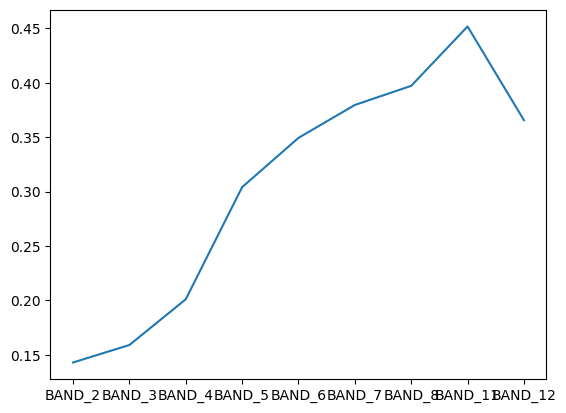

In [382]:
best_simulated = new_data_simulated[[244]]
plt.plot(best_simulated);

In [383]:
inner = pd.concat([new_data_measured, best_simulated], axis = 1)
inner

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,244
BAND_2,934,948,921,948,964,975,969,968,958,946,...,795,887,932,917,924,934,922,915,923,0.143007
BAND_3,803,812,788,805,826,840,836,823,821,809,...,693,763,802,800,778,784,772,769,780,0.159057
BAND_4,760,758,724,759,789,814,806,802,785,763,...,543,676,762,734,738,749,755,743,736,0.201078
BAND_5,908,925,905,919,932,962,964,935,919,926,...,835,869,917,911,877,881,879,883,893,0.304068
BAND_6,1140,1160,1170,1145,1160,1199,1159,1123,1148,1135,...,1316,1146,1140,1169,1114,1099,1109,1103,1105,0.349395
BAND_7,1276,1291,1305,1279,1297,1337,1307,1250,1282,1278,...,1463,1286,1279,1307,1242,1259,1242,1250,1252,0.379612
BAND_8,1309,1341,1337,1297,1326,1369,1329,1292,1294,1307,...,1493,1303,1293,1327,1262,1261,1252,1259,1271,0.397207
BAND_11,2411,2405,2351,2428,2501,2486,2515,2498,2471,2435,...,1469,2228,2407,2351,2254,2300,2304,2328,2377,0.451754
BAND_12,1486,1500,1433,1491,1568,1542,1563,1564,1531,1515,...,803,1320,1490,1446,1404,1423,1445,1435,1488,0.365666


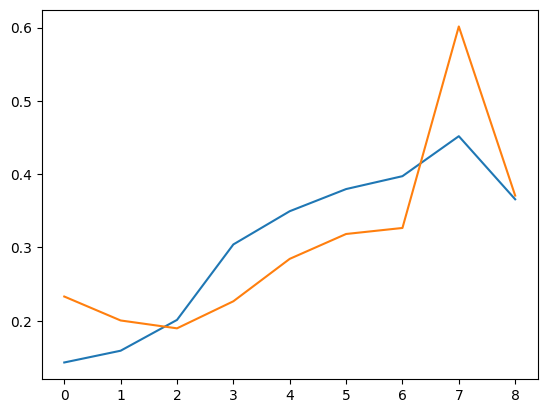

In [384]:
plt.plot(np.array(inner)[:,-1]);
plt.plot(np.array(inner)[:,0]/np.mean(np.array(inner)[:,0])*np.mean(np.array(inner)[:,-1]));

In [385]:
chloro[ind]

26.88818131199099

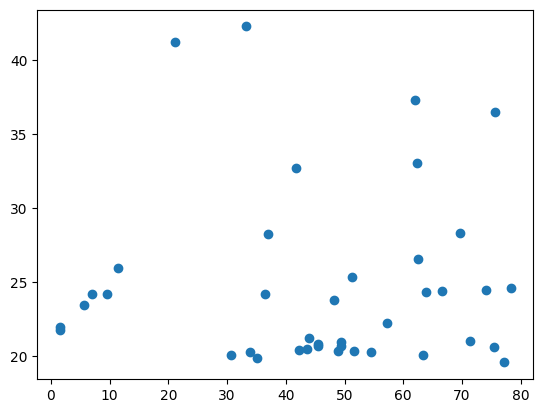

In [386]:
plt.scatter(chlorophyll, df_chloro);

In [343]:
chlorop = pd.concat([chlorophyll, df_chloro], axis = 1)

In [387]:
chlorop.to_excel("/Users/BSibiya/Desktop/study_area/output.xlsx")  